In [2]:
import torch, torchvision, torchmetrics
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

## Data Preparation

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [4]:
from pathlib import Path
from torchvision import datasets, transforms


DATA_DIR = Path("data/")
TRAIN_DIR = DATA_DIR / "train"
TEST_DIR = DATA_DIR / "test"
VALID_DIR = DATA_DIR / "valid"

In [5]:
transform = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.ToTensor(), 
])


In [13]:
train_data = datasets.ImageFolder(root=TRAIN_DIR,
                                  transform=transform,
                                  target_transform=None)

test_data = datasets.ImageFolder(root=TEST_DIR,
                                  transform=transform,
                                  target_transform=None)

valid_data = datasets.ImageFolder(root=VALID_DIR,
                                  transform=transform,
                                  target_transform=None)

class_names = train_data.classes

print(f"Train data length: {len(train_data)}")
print(f"Test data length: {len(test_data)}")
print(f"Valid data length: {len(valid_data)}")

Train data length: 6360
Test data length: 307
Valid data length: 591


In [14]:
from torch.utils.data import DataLoader

torch.manual_seed(0)

BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              shuffle=True,
                              num_workers=NUM_WORKERS)

test_dataloader = DataLoader(dataset=test_data,
                              batch_size=BATCH_SIZE,
                              shuffle=False,
                              num_workers=NUM_WORKERS)

valid_dataloader = DataLoader(dataset=valid_data,
                              batch_size=BATCH_SIZE,
                              shuffle=False,
                              num_workers=NUM_WORKERS)

print(f"Train dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}")
print(f"Test dataloader: {len(test_dataloader)} batches of {BATCH_SIZE}")
print(f"Valid dataloader: {len(valid_dataloader)} batches of {BATCH_SIZE}")

Train dataloader: 199 batches of 32
Test dataloader: 10 batches of 32
Valid dataloader: 19 batches of 32


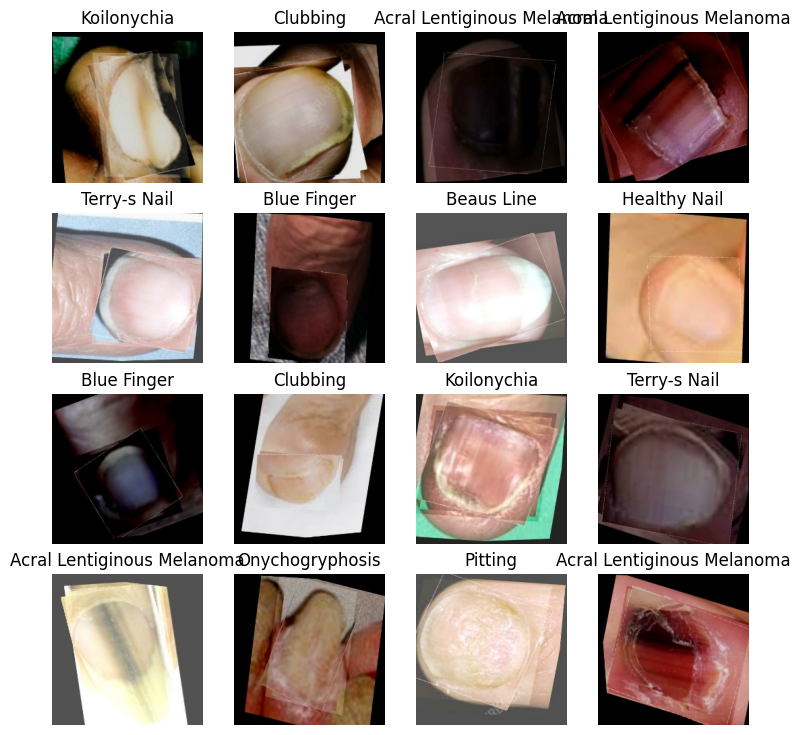

In [16]:
# Plot more images
fig = plt.figure(figsize=(9, 9))
rows, cols = 4, 4
for i in range(1, rows*cols+1):
    random_idx = torch.randint(0, len(train_data), size=[1]).item()
    img, label = train_data[random_idx]
    fig.add_subplot(rows, cols, i)
    plt.imshow(img.squeeze().permute(1, 2, 0), cmap="gray")
    plt.title(class_names[label])
    plt.axis(False)

In [ ]:
from torchvision.models import vgg16, VGG16_Weights

model = vgg16(weights=VGG16_Weights.DEFAULT)

